<a href="https://colab.research.google.com/github/juan-villa02/medical_vqa_vlm/blob/main/code/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQA Model - BERT + ResNet18

## Libraries/Dependencies

In [1]:
# PyTorch framework
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils
# Image and mask handling
from PIL import Image
from skimage import transform
import scipy.io as sio
# Transformers (Hugginface)
from transformers import AutoTokenizer, BertForQuestionAnswering, VisualBertModel, VisualBertForQuestionAnswering, VisualBertConfig
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Extra dependencies
import json
import os
from tqdm import tqdm
import zipfile

In [2]:
# Set training device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Paths & Data Extraction

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_dir = '.'
path_dir = '/content/drive/MyDrive/TFG Juan Villanueva/databases_qa.zip'

In [5]:
# Data folder
data_folder = './data/'

In [6]:
# ISIC_2016 database
train_ISIC_path = 'databases_qa/ISIC_2016'

In [7]:
# def filter_json(json_file, images_dir, output_file):
#    filtered_data = []

#    with open(json_file, 'r') as f:
#        data = json.load(f)

#        for item in data:
#            image_id = item['image_id'] + '.jpg'
#            image_path = os.path.join(images_dir, image_id)

#            # Check if the image file exists
#            if os.path.exists(image_path):
#                filtered_data.append(item)

#    # Write the filtered data to the output JSON file
#    with open(output_file, 'w') as f:
#        json.dump(filtered_data, f, indent=4)

#    return

In [8]:
# json_file = '/content/data/databases_qa/ISIC_2016/qa_ISIC.json'
# images_dir = '/content/data/databases_qa/ISIC_2016/images/ISBI2016_ISIC_Part1_Test_Data_orig'
# output_file = 'qa_filtered_ISIC.json'
# filter_json(json_file, images_dir, output_file)

In [9]:
# ISIC_2016 database (images and masks)
train_extra_ISIC_path = 'ISBI2016_ISIC_Part3_Training_Data_orig'

In [10]:
# Pizarro database (images)
pizarro_path = 'databases_qa/pizarro'

In [11]:
# Function to extract databases from the main zip file
def extract_databases(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [12]:
# Extract all databases from the main zip file
if path_dir != '.':
  extract_databases(path_dir, data_folder)

In [13]:
# ISIC_2016 images
database1_path = os.path.join(data_folder, train_ISIC_path)

In [14]:
# Pizarro images
# 500 imágenes; Las 46 primeras son más complejas, en cuanto a diagnóstico. (Entrega 1) El resto están más equilibradas (Entrega 2-5)
database2_path = os.path.join(data_folder, pizarro_path)

## VQA Dataset - Images, Masks, & QA

In [15]:
# Dataset class to load images and questions
class VQADataset(Dataset):
    def __init__(self, data_dir, json_file, tokenizer=None, transform=None, extraPath=None):
        self.data_dir = data_dir
        self.images_dir = os.path.join(self.data_dir, 'images')
        self.masks_dir = os.path.join(self.data_dir, 'masks')

        # Handle special ISIC data folder
        self.extraPath = extraPath
        if self.extraPath is not None:
            self.images_dir = os.path.join(self.images_dir, self.extraPath)
            self.masks_dir = os.path.join(self.masks_dir, self.extraPath)

        self.transform = transform
        self.tokenizer = tokenizer

        with open(json_file, 'r') as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        item = self.data[idx]
        image_path = os.path.join(self.images_dir, item['image_id'])

        # Ensure the image ID ends with ".jpg"
        if not image_path.endswith(".jpg"):
            image_path += ".jpg"

        # Check if the image is available
        try:
          image = Image.open(image_path).convert('RGB')

          # Case 1: Pizarro dataset
          if self.extraPath is None:
            mask_id = item['image_id'].split('.')[0]
            mask_name = 'L' + mask_id + '.pgm'
            mask_path = os.path.join(self.masks_dir, mask_name)
            mask = Image.open(mask_path)

          # Case 2: ISIC dataset
          else:
            mask_path = os.path.join(self.masks_dir, item['image_id']) + '_Segmentation.png'
            mask = Image.open(mask_path)

          if self.transform:
              image, mask = self.transform((image, mask))

          # Store questions and answers in two different arrays
          qa_pairs = item['qa_pairs']
          questions = [qa['question'] for qa in qa_pairs]
          answers = [qa['answer'] for qa in qa_pairs]

        except FileNotFoundError as e:

          image = None
          mask = None
          questions = None
          answers = None

        return image, mask, questions, answers

## Load pre-trained ResNet18

In [16]:
# Load ResNet-18 model from .pth file
def load_resnet(path, optimizer=None, scheduler=None):
    resnet = models.resnet18()
    # Remove final fully connected layer and avg pooling (we do not want the model to return labels but features with dimension)
    resnet.fc = nn.Identity()
    resnet.avgpool = nn.Identity()

    # Load the weights
    state_dict = torch.load(path, map_location=device)['state_dict']

    # Remove unexpected keys if they exist
    unexpected_keys = ['fc.weight', 'fc.bias']
    for key in unexpected_keys:
        if key in state_dict:
            del state_dict[key]

    # Load the weights
    resnet.load_state_dict(state_dict)
    resnet.eval()

    if optimizer is not None:
        optimizer.load_state_dict(torch.load(path)['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(path)['scheduler'])

    resnet.to(device)

    return resnet, optimizer, scheduler

In [17]:
model_source_path = '/content/drive/MyDrive/TFG Juan Villanueva/codigo diagnostico/bestdiagNet.pth'

In [18]:
resnet, optimizer, scheduler = load_resnet(model_source_path)

In [19]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Image Transformations

In [20]:
class CropByMask(object):
    """Recortamos la imagen usando la máscara de la lesión.

    Args:
        border (tupla o int): El borde de recorte alrededor de la máscara. Es sabido que el análisis del borde
        de la lesión con la piel circudante es importante para los dermatólogos, por lo que puede ser interesante
        dejar una guarda.
        Si es una tupla, entonces es (bordery,borderx)
    """

    def __init__(self, border):
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border

    def __call__(self, sample):

        image, mask = np.array(sample[0]), np.array(sample[1])

        h, w = image.shape[:2]
        #Calculamos los índices del bounding box para hacer el cropping
        sidx=np.nonzero(mask)
        minx=np.maximum(sidx[1].min()-self.border[1],0)
        maxx=np.minimum(sidx[1].max()+1+self.border[1],w)
        miny=np.maximum(sidx[0].min()-self.border[0],0)
        maxy=np.minimum(sidx[0].max()+1+self.border[1],h)
        #Recortamos la imagen
        image=image[miny:maxy,minx:maxx,...]
        mask=mask[miny:maxy,minx:maxx]

        return image, mask

In [21]:
class Rescale(object):
    """Rescales the image to a desired size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is the output_size.
            If int, the smaller of the image edges is matched to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):

        image_np, mask_np = sample[0], sample[1]

        # Get the height and width of the image
        h, w = image_np.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        # Resize the image using scikit-image's resize function
        resized_image = transform.resize(image_np, (new_h, new_w))
        resized_mask = transform.resize(mask_np, (new_h, new_w))

        # Convert the resized NumPy array back to a PIL image
        resized_image_pil = Image.fromarray((resized_image * 255).astype(np.uint8))
        resized_mask_pil = Image.fromarray((resized_mask * 255).astype(np.uint8))

        #return resized_image_pil, resized_mask_pil
        return resized_image, resized_mask

In [22]:
class CenterCrop(object):
    """Crop the central area of the image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):

        image, mask = sample[0], sample[1]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        rem_h = h - new_h
        rem_w = w - new_w

        if h>new_h:
            top = int(rem_h/2)
        else:
            top=0

        if w>new_w:
            left = int(rem_w/2)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return image, mask

In [23]:
class ToTensor(object):
    """Converts the image ndarray to a tensor."""

    def __call__(self, sample):

        image, mask = sample[0], sample[1]
        # Change the axes
        # numpy image: H x W x C
        # torch image: C x H x W
        # image = np.array(image)
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)

        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(0)

        return image, mask


In [24]:
class Normalize(object):
    """Normalizes the image by subtracting the mean and dividing by the standard deviations.

    Args:
        mean: The vector containing the means.
        std: The vector containing the standard deviations.
    """

    def __init__(self, mean, std):
        assert len(mean) == len(std), 'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, sample):

        image, mask = sample[0], sample[1]

        # c, h, w = image.shape
        # assert c==len(self.mean), 'Length of mean and image is not the same'

        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        # Normalize the image
        # image = (image - mean[:, None, None]) / std[:, None, None]
        image.sub_(mean[:, None, None]).div_(std[:, None, None])

        return image, mask

In [25]:
# Train ISIC Dataset------------------------------------------------------------
train_dataset_isic = VQADataset(data_dir=database1_path,
                           json_file='/content/data/databases_qa/ISIC_2016/qa_filtered_ISIC.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            CropByMask(15),
                            Rescale(224),
                            CenterCrop(224),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]),
                            extraPath=train_extra_ISIC_path)
# # Test ISIC Dataset--------------------------------------------------------------
# test_dataset_isic = VQADataset(data_dir=database1_test_path,
#                            json_file='/content/data/databases_qa/ISIC_2016/qa_ISIC.json',
#                            tokenizer=None,
#                            transform=transforms.Compose([
#                             Rescale((224,224)),
#                             ToTensor(),
#                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#                             ]))

In [26]:
# Train Pizarro Dataset------------------------------------------------------------
train_dataset_pizarro = VQADataset(data_dir=database2_path,
                           json_file='/content/data/databases_qa/pizarro/qa_pizarro.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            CropByMask(15),
                            Rescale(224),
                            CenterCrop(224),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]))

## Define the all the possible answers within both datasets

In [27]:
# Extract all answers from the dataset
all_answers = [answer for _, _, _, answers in train_dataset_pizarro for answer in answers]
# Obtain unique answer values
unique_answers = list(set(all_answers))

In [28]:
unique_answers

['No chrysalis is observed.',
 ' chrysalis is observed.',
 'Yes, clear and dominant peripheral projections are present.',
 'No whitish blue veil is observed.',
 'The lesion has been follow-up with previous dermoscopy, due to symptoms.',
 ' large globules/cobblestone are observed.',
 'Yes, subtle chrysalis is observed.',
 'The presence of dysplasia is not available.',
 'The histology diagnostic indicates lentiginous melanocytic nevus (lmn).',
 'Yes, clear and dominant pigmented reticulum is observed.',
 'The presence of dysplasia is .',
 'The presence of dysplasia is not applicable.',
 'Yes, clear peripheral globules are observed.',
 'Yes, clear and dominant homogeneous area without vessels is observed.',
 'The peripheral globular pattern is regular conventional.',
 'The diagnostic impression is spitz/reed nevus.',
 'The histology diagnostic indicates spitz nevus (sn).',
 'Yes, subtle pigmented reticulum is observed.',
 'The peripheral globular pattern is focal bursting.',
 'The diagnos

In [29]:
# Create dictionaries id2label and label2id
id2label = {i: label for i, label in enumerate(unique_answers)}
label2id = {label: i for i, label in enumerate(unique_answers)}

In [30]:
id2label

{0: 'No chrysalis is observed.',
 1: ' chrysalis is observed.',
 2: 'Yes, clear and dominant peripheral projections are present.',
 3: 'No whitish blue veil is observed.',
 4: 'The lesion has been follow-up with previous dermoscopy, due to symptoms.',
 5: ' large globules/cobblestone are observed.',
 6: 'Yes, subtle chrysalis is observed.',
 7: 'The presence of dysplasia is not available.',
 8: 'The histology diagnostic indicates lentiginous melanocytic nevus (lmn).',
 9: 'Yes, clear and dominant pigmented reticulum is observed.',
 10: 'The presence of dysplasia is .',
 11: 'The presence of dysplasia is not applicable.',
 12: 'Yes, clear peripheral globules are observed.',
 13: 'Yes, clear and dominant homogeneous area without vessels is observed.',
 14: 'The peripheral globular pattern is regular conventional.',
 15: 'The diagnostic impression is spitz/reed nevus.',
 16: 'The histology diagnostic indicates spitz nevus (sn).',
 17: 'Yes, subtle pigmented reticulum is observed.',
 18: '

In [31]:
# Required tensor with the label IDs
answers_ids_tensor = torch.arange(len(id2label), dtype=torch.float, device=device)
answers_ids_tensor

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101.], device='cuda:0')

In [32]:
# Pizarro dataset
pizarro_dataloader = DataLoader(train_dataset_pizarro, batch_size=5, shuffle=True)
train_isic_dataloader = DataLoader(train_dataset_isic, batch_size=5, shuffle=True)

In [33]:
# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Show a batch of images."""

    # Store images, questions and answers
    images_batch, masks_batch, questions_batch, answers_batch = \
            sample_batched[0], sample_batched[1], sample_batched[2], sample_batched[3]

    # Identify the batch size to define the grid
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    # Generate the grid
    grid = utils.make_grid(images_batch)

    # Convert to numpy and denormalize
    grid = grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')
    plt.axis('off')
    plt.show()

0 [('How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?'), ('Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?'), ('Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.'), ('What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?'), ('What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patt

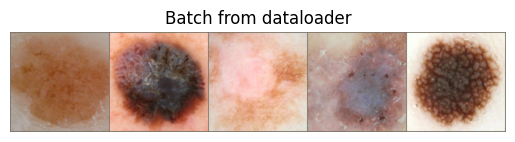

1 [('How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?'), ('Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?'), ('Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.'), ('What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?'), ('What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patt

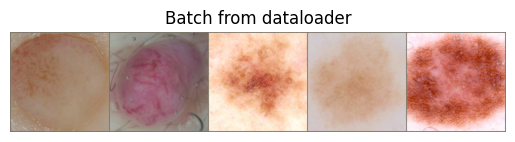

In [34]:
# Iterate over the dataloader and visualize batches
for i_batch, sample_batched in enumerate(train_isic_dataloader):
    print(i_batch, sample_batched[2])
    show_batch(sample_batched)

    # Show only the data of the 3rd batch and stop.
    if i_batch == 1:
        break

## Image Feature Extraction

In [35]:
for images, masks, questions, answers in pizarro_dataloader:
  print(images.size())
  break

torch.Size([5, 3, 224, 224])


In [36]:
def extract_image_features(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    num_samples = len(dataloader.dataset)

    output_shape = (7,7,512) # Keep dimensionality of outputs (layer 4)

    # Calculate the total number of features
    num_features = np.prod(output_shape)

    features = np.zeros((num_samples, *output_shape), dtype=np.float32)
    sample_idx = 0

    with torch.no_grad():
        for sample in dataloader:
            # Get images
            inputs = sample[0].to(device).float()

            # Forward pass
            outputs = model(inputs)

            outputs_reshaped = outputs.reshape(outputs.size(0), *output_shape)

            # Store features
            batch_size = inputs.size(0)
            # features[sample_idx:sample_idx + batch_size, :] = outputs_flat.cpu().numpy()
            features[sample_idx:sample_idx + batch_size, :] = outputs_reshaped.cpu().numpy()
            sample_idx += batch_size

    return torch.tensor(features, device=device)

In [37]:
features_pizarro = extract_image_features(resnet, pizarro_dataloader)

In [38]:
features_pizarro.size()

torch.Size([500, 7, 7, 512])

In [39]:
# Function to print GPU memory usage
def print_gpu_memory():
    print(f"Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Memory reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

## VQA Model Creation

In [85]:
class VQAModel(nn.Module):
    def __init__(self, resnet, vlm, tokenizer):
        super(VQAModel, self).__init__()

        # Pre-trained ResNet model
        self.resnet = resnet
        # Vision Language Model
        self.vlm = vlm
        # Tokenizer
        self.tokenizer = tokenizer
        # Freeze parameters of the ResNet model
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, image_features, question, labels_idxs=None, training=False):

        # image_features -> array with visual features for the specific image (7x7x512)
        # question -> individual question within the image batch
        # labels_idx -> tensor with shape (0, ..., num_labels-1)
        # training; boolean to determine the mode (train/evaluation)

        # Prepare image inputs -> (batch_size, visual_seq_length, visual_embedding_dim)
        flattened_embedding = image_features.view(-1, 512) # (49x512)
        visual_embeds = flattened_embedding.unsqueeze(0) # (1x49x512)

        # Token type and attention masks -> (batch_size, visual_seq_length)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long, device=device)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float, device=device)

        # Tokenize question
        tokenized_question = self.tokenizer(question,
                                            return_token_type_ids=True,
                                            return_attention_mask=True,
                                            add_special_tokens=True,
                                            return_tensors='pt')

        # Input for the VLM model (refer to VisualBert to understand the shapes)
        input_dict = {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
            "input_ids": tokenized_question['input_ids'].to(device),
            "token_type_ids": tokenized_question['token_type_ids'].to(device),
            "attention_mask": tokenized_question['attention_mask'].to(device),
        }

        # Training mode: track gradients
        if training:

            output = self.vlm(**input_dict, labels=labels_idxs)
            logits = output.logits
            loss = output.loss
            attentions = output.attentions

            del output

        # Evaluation mode: no gradients
        else:
            with torch.no_grad():
                output = self.vlm(**input_dict)
                logits = output.logits

        # # Check for memory usage
        # print_gpu_memory()

        return logits, loss, attentions

### Define LLM & Tokenizer

In [78]:
# Pre-trained base case for VQA provided in documentation
# tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
# bertModel = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
# Modify the visual embedding config so that size of the features matches
configuration = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa",
                                                 visual_embedding_dim=512,
                                                 num_labels=answers_ids_tensor.shape[0],
                                                 output_attentions=True)
visualBert = VisualBertForQuestionAnswering(configuration)

## Training Loop

In [100]:
# Create the VQA Model and pass it to the GPU
vqa_model = VQAModel(resnet, visualBert, tokenizer)

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vqa_model.to(device)

VQAModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [102]:
# Define hyperparameters
learning_rate = 1e-4
num_epochs = 4

In [103]:
# Define optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vqa_model.parameters()), lr=learning_rate)

In [75]:
# Extract all image features for the dataloader
with torch.no_grad():
    image_features = extract_image_features(vqa_model.resnet, pizarro_dataloader)

In [76]:
image_features.size()

torch.Size([500, 7, 7, 512])

In [ ]:
# Set the model in training mode
vqa_model.train()
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    num_batches = 0
    text_results = []
    for images, masks, questions, answers in tqdm(pizarro_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):

        # Track batch loss
        batch_loss = 0.0

        # Transpose questions and answers
        questions = np.transpose(questions)
        answers = np.transpose(answers)
        # Store shape for iteration
        num_images, num_questions_per_image = np.shape(questions)

        # Iterate over all questions for each image
        for image_idx in range(num_images):
          for question_idx in range(num_questions_per_image):

            # Avoid using previous gradients
            optimizer.zero_grad()

            #Forward pass
            outputs, loss, attentions = vqa_model(image_features[image_idx], questions[image_idx,question_idx], answers_ids_tensor, training=True)

            # Backpropagation
            loss.backward()
            optimizer.step()

            batch_loss += loss.item() / (num_images * num_questions_per_image)

            # Store the text predicted answers, the ground truth and corresponding question
            probabilities = torch.softmax(outputs, dim=-1)
            pred_idx = torch.argmax(probabilities, dim=-1)
            pred_answer = id2label[pred_idx.item()]

            text_results.append({
                  "Image ID": image_idx,
                  "Question": questions[image_idx,question_idx],
                  "Ground Truth": answers[image_idx, question_idx],
                  "Prediction": pred_answer
                  })

            # Remove unnecessary tensors from memory
            del loss
            del outputs

        # Print batch loss
        print(f"Batch Loss: {batch_loss}")

        # Accumulate the total loss and num of batches
        total_loss += batch_loss
        num_batches += 1

    # Aaverage training loss for the epoch
    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss}")

    # Save trained model after each epoch
    torch.save(vqa_model.state_dict(), f'trained_vqa_model_epoch{epoch+1}.pth')

Epoch 1/4:   1%|          | 1/100 [00:38<1:04:17, 38.97s/batch]

Batch Loss: 44171.17724431821


Epoch 1/4:   2%|▏         | 2/100 [01:17<1:03:16, 38.74s/batch]

Batch Loss: 44108.14845170455


Epoch 1/4:   3%|▎         | 3/100 [01:56<1:02:25, 38.62s/batch]

Batch Loss: 44060.51004261368


Epoch 1/4:   4%|▍         | 4/100 [02:35<1:02:14, 38.91s/batch]

Batch Loss: 44040.727031249946


Epoch 1/4:   5%|▌         | 5/100 [03:13<1:01:26, 38.80s/batch]

Batch Loss: 44034.65231534094


Epoch 1/4:   6%|▌         | 6/100 [03:52<1:00:39, 38.72s/batch]

Batch Loss: 44033.52727272727


Epoch 1/4:   7%|▋         | 7/100 [04:31<59:54, 38.65s/batch]  

Batch Loss: 44032.10073153409


Epoch 1/4:   8%|▊         | 8/100 [05:09<59:11, 38.60s/batch]

Batch Loss: 44031.66097301135


Epoch 1/4:   9%|▉         | 9/100 [05:47<58:27, 38.55s/batch]

Batch Loss: 44031.32995028414


Epoch 1/4:  10%|█         | 10/100 [06:26<57:51, 38.57s/batch]

Batch Loss: 44031.482649147685


Epoch 1/4:  11%|█         | 11/100 [07:05<57:16, 38.62s/batch]

Batch Loss: 44030.87265624994


Epoch 1/4:  12%|█▏        | 12/100 [07:44<56:46, 38.71s/batch]

Batch Loss: 44030.582919034074


Epoch 1/4:  13%|█▎        | 13/100 [08:22<56:00, 38.62s/batch]

Batch Loss: 44029.43470880685


Epoch 1/4:  14%|█▍        | 14/100 [09:01<55:15, 38.55s/batch]

Batch Loss: 44029.9370738637


Epoch 1/4:  15%|█▌        | 15/100 [09:42<55:47, 39.39s/batch]

Batch Loss: 44029.17401988636


Epoch 1/4:  16%|█▌        | 16/100 [10:20<54:44, 39.10s/batch]

Batch Loss: 44028.2779119318


Epoch 1/4:  17%|█▋        | 17/100 [10:59<53:45, 38.86s/batch]

Batch Loss: 44027.74629261363


Epoch 1/4:  18%|█▊        | 18/100 [11:37<52:54, 38.71s/batch]

Batch Loss: 44028.13443892047


Epoch 1/4:  19%|█▉        | 19/100 [12:16<52:17, 38.74s/batch]

Batch Loss: 44027.361654829576


Epoch 1/4:  20%|██        | 20/100 [12:54<51:30, 38.64s/batch]

Batch Loss: 44027.06598721592


Epoch 1/4:  21%|██        | 21/100 [13:33<50:45, 38.54s/batch]

Batch Loss: 44026.67550426139


Epoch 1/4:  22%|██▏       | 22/100 [14:11<50:04, 38.52s/batch]

Batch Loss: 44026.52116477274


Epoch 1/4:  23%|██▎       | 23/100 [14:49<49:24, 38.50s/batch]

Batch Loss: 44026.57914772728


Epoch 1/4:  24%|██▍       | 24/100 [15:28<48:40, 38.43s/batch]

Batch Loss: 44026.62524857953


Epoch 1/4:  25%|██▌       | 25/100 [16:06<48:02, 38.43s/batch]

Batch Loss: 44026.44571732949


Epoch 1/4:  26%|██▌       | 26/100 [16:45<47:38, 38.63s/batch]

Batch Loss: 44026.27149857956


Epoch 1/4:  27%|██▋       | 27/100 [17:23<46:51, 38.51s/batch]

Batch Loss: 44026.257663352306


Epoch 1/4:  28%|██▊       | 28/100 [18:02<46:11, 38.50s/batch]

Batch Loss: 44026.22627130682


Epoch 1/4:  29%|██▉       | 29/100 [18:40<45:30, 38.46s/batch]

Batch Loss: 44026.24654829548


Epoch 1/4:  30%|███       | 30/100 [19:19<44:50, 38.43s/batch]

Batch Loss: 44026.05453125001


Epoch 1/4:  31%|███       | 31/100 [19:57<44:13, 38.46s/batch]

Batch Loss: 44026.13594460226


Epoch 1/4:  32%|███▏      | 32/100 [20:36<43:33, 38.43s/batch]

Batch Loss: 44026.153615056784


Epoch 1/4:  33%|███▎      | 33/100 [21:15<43:10, 38.66s/batch]

Batch Loss: 44026.07509943182


Epoch 1/4:  34%|███▍      | 34/100 [21:53<42:27, 38.59s/batch]

Batch Loss: 44026.06298295449


Epoch 1/4:  35%|███▌      | 35/100 [22:32<41:43, 38.52s/batch]

Batch Loss: 44199.255909090934


Epoch 1/4:  36%|███▌      | 36/100 [23:10<41:05, 38.53s/batch]

Batch Loss: 44026.47301846591


Epoch 1/4:  37%|███▋      | 37/100 [23:49<40:30, 38.58s/batch]

Batch Loss: 44026.05890624998


Epoch 1/4:  38%|███▊      | 38/100 [24:27<39:51, 38.58s/batch]

Batch Loss: 44025.90693181814


Epoch 1/4:  39%|███▉      | 39/100 [25:06<39:11, 38.55s/batch]

Batch Loss: 44028.05885653406


Epoch 1/4:  40%|████      | 40/100 [25:45<38:40, 38.68s/batch]

Batch Loss: 44026.16563920451


Epoch 1/4:  41%|████      | 41/100 [26:23<37:59, 38.64s/batch]

Batch Loss: 44025.95336647728


Epoch 1/4:  42%|████▏     | 42/100 [27:02<37:17, 38.58s/batch]

Batch Loss: 44025.92977272728


Epoch 1/4:  43%|████▎     | 43/100 [27:40<36:36, 38.53s/batch]

Batch Loss: 44025.90051136368


Epoch 1/4:  44%|████▍     | 44/100 [28:19<35:59, 38.55s/batch]

Batch Loss: 44025.812102272714


Epoch 1/4:  45%|████▌     | 45/100 [28:58<35:22, 38.59s/batch]

Batch Loss: 44028.008664772744


Epoch 1/4:  46%|████▌     | 46/100 [29:36<34:41, 38.55s/batch]

Batch Loss: 44026.05664772732


Epoch 1/4:  47%|████▋     | 47/100 [30:15<34:04, 38.57s/batch]

Batch Loss: 44025.93539062499


Epoch 1/4:  48%|████▊     | 48/100 [30:54<33:37, 38.80s/batch]

Batch Loss: 44025.875646306806


Epoch 1/4:  49%|████▉     | 49/100 [31:33<32:56, 38.75s/batch]

Batch Loss: 44025.80014914773


Epoch 1/4:  50%|█████     | 50/100 [32:11<32:15, 38.72s/batch]

Batch Loss: 44025.86726562495


Epoch 1/4:  51%|█████     | 51/100 [32:50<31:37, 38.72s/batch]

Batch Loss: 44025.939062500016


Epoch 1/4:  52%|█████▏    | 52/100 [33:29<31:04, 38.84s/batch]

Batch Loss: 44025.885014204534


Epoch 1/4:  53%|█████▎    | 53/100 [34:09<30:34, 39.04s/batch]

Batch Loss: 44025.80456676132


Epoch 1/4:  54%|█████▍    | 54/100 [34:47<29:48, 38.88s/batch]

Batch Loss: 44025.78911931814


Epoch 1/4:  55%|█████▌    | 55/100 [35:26<29:15, 39.01s/batch]

Batch Loss: 44025.8509232955


Epoch 1/4:  56%|█████▌    | 56/100 [36:05<28:31, 38.90s/batch]

Batch Loss: 44025.8880894886


Epoch 1/4:  57%|█████▋    | 57/100 [36:43<27:46, 38.77s/batch]

Batch Loss: 44025.90212357952


Epoch 1/4:  58%|█████▊    | 58/100 [37:22<27:06, 38.72s/batch]

Batch Loss: 44025.88813920455


Epoch 1/4:  59%|█████▉    | 59/100 [38:01<26:27, 38.72s/batch]

Batch Loss: 44025.88507812496


Epoch 1/4:  60%|██████    | 60/100 [38:40<25:50, 38.76s/batch]

Batch Loss: 44025.81292613638


Epoch 1/4:  61%|██████    | 61/100 [39:18<25:11, 38.76s/batch]

Batch Loss: 44025.79260653407


Epoch 1/4:  62%|██████▏   | 62/100 [39:58<24:36, 38.86s/batch]

Batch Loss: 44025.816874999975


Epoch 1/4:  63%|██████▎   | 63/100 [40:36<23:52, 38.73s/batch]

Batch Loss: 44025.84240767046


Epoch 1/4:  64%|██████▍   | 64/100 [41:14<23:11, 38.65s/batch]

Batch Loss: 44025.76623579546


Epoch 1/4:  65%|██████▌   | 65/100 [41:53<22:33, 38.67s/batch]

Batch Loss: 44025.72677556819


Epoch 1/4:  66%|██████▌   | 66/100 [42:32<21:58, 38.79s/batch]

Batch Loss: 44025.74638494315


Epoch 1/4:  67%|██████▋   | 67/100 [43:11<21:20, 38.81s/batch]

Batch Loss: 44025.747315341


Epoch 1/4:  68%|██████▊   | 68/100 [43:50<20:41, 38.80s/batch]

Batch Loss: 44025.7561150568


Epoch 1/4:  69%|██████▉   | 69/100 [44:29<20:06, 38.93s/batch]

Batch Loss: 44025.810113636326


Epoch 1/4:  70%|███████   | 70/100 [45:08<19:23, 38.79s/batch]

Batch Loss: 44025.680546874995


Epoch 1/4:  71%|███████   | 71/100 [45:46<18:44, 38.78s/batch]

Batch Loss: 44027.770234375


Epoch 1/4:  72%|███████▏  | 72/100 [46:25<18:09, 38.91s/batch]

Batch Loss: 44025.79705965909


Epoch 1/4:  73%|███████▎  | 73/100 [47:05<17:34, 39.04s/batch]

Batch Loss: 44025.731754261345


Epoch 1/4:  74%|███████▍  | 74/100 [47:44<16:57, 39.14s/batch]

Batch Loss: 44025.724105113615


Epoch 1/4:  75%|███████▌  | 75/100 [48:24<16:20, 39.21s/batch]

Batch Loss: 44025.653316761345


Epoch 1/4:  76%|███████▌  | 76/100 [49:04<15:47, 39.49s/batch]

Batch Loss: 44025.711384943155


Epoch 1/4:  77%|███████▋  | 77/100 [49:43<15:07, 39.44s/batch]

Batch Loss: 44025.668281249986


Epoch 1/4:  78%|███████▊  | 78/100 [50:22<14:25, 39.32s/batch]

Batch Loss: 44025.666839488666


Epoch 1/4:  79%|███████▉  | 79/100 [51:01<13:44, 39.24s/batch]

Batch Loss: 44025.61546874996


Epoch 1/4:  80%|████████  | 80/100 [51:40<13:02, 39.14s/batch]

Batch Loss: 44025.7116122159


Epoch 1/4:  81%|████████  | 81/100 [52:19<12:20, 38.95s/batch]

Batch Loss: 44025.64769886361


Epoch 1/4:  82%|████████▏ | 82/100 [52:58<11:42, 39.03s/batch]

Batch Loss: 44025.67681818174


Epoch 1/4:  83%|████████▎ | 83/100 [53:37<11:05, 39.16s/batch]

Batch Loss: 44025.7251207386


Epoch 1/4:  84%|████████▍ | 84/100 [54:16<10:23, 38.97s/batch]

Batch Loss: 44027.484438920445


Epoch 1/4:  85%|████████▌ | 85/100 [54:54<09:41, 38.78s/batch]

Batch Loss: 44025.83434659089


Epoch 1/4:  86%|████████▌ | 86/100 [55:32<08:59, 38.55s/batch]

Batch Loss: 44025.70987215909


Epoch 1/4:  87%|████████▋ | 87/100 [56:10<08:19, 38.41s/batch]

Batch Loss: 44025.68328835232


Epoch 1/4:  88%|████████▊ | 88/100 [56:48<07:39, 38.29s/batch]

Batch Loss: 44025.65409801136


Epoch 1/4:  89%|████████▉ | 89/100 [57:26<06:59, 38.12s/batch]

Batch Loss: 44025.659403409096


Epoch 1/4:  90%|█████████ | 90/100 [58:04<06:22, 38.22s/batch]

Batch Loss: 44025.66472301139


Epoch 1/4:  91%|█████████ | 91/100 [58:42<05:43, 38.12s/batch]

Batch Loss: 44025.626470170486


Epoch 1/4:  92%|█████████▏| 92/100 [59:20<05:04, 38.08s/batch]

Batch Loss: 44025.69154119321


Epoch 1/4:  93%|█████████▎| 93/100 [59:58<04:26, 38.05s/batch]

Batch Loss: 44025.59338778414


Epoch 1/4:  94%|█████████▍| 94/100 [1:00:36<03:48, 38.04s/batch]

Batch Loss: 44025.64416193182


Epoch 1/4:  95%|█████████▌| 95/100 [1:01:14<03:10, 38.08s/batch]

Batch Loss: 44025.62390625001


Epoch 1/4:  96%|█████████▌| 96/100 [1:01:53<02:32, 38.08s/batch]

Batch Loss: 44025.61797585229


Epoch 1/4:  97%|█████████▋| 97/100 [1:02:31<01:54, 38.23s/batch]

Batch Loss: 44025.68458806814


Epoch 1/4:  98%|█████████▊| 98/100 [1:03:09<01:16, 38.26s/batch]

Batch Loss: 44025.69909090909


Epoch 1/4:  99%|█████████▉| 99/100 [1:03:48<00:38, 38.35s/batch]

Batch Loss: 44025.683728693184


Epoch 1/4: 100%|██████████| 100/100 [1:04:26<00:00, 38.67s/batch]

Batch Loss: 44025.711875
Epoch 1, Average Loss: 44031.15991051135



Epoch 2/4:   1%|          | 1/100 [00:38<1:03:47, 38.66s/batch]

Batch Loss: 44025.59703835222


Epoch 2/4:   2%|▏         | 2/100 [01:18<1:03:48, 39.06s/batch]

Batch Loss: 44025.65438210227


Epoch 2/4:   3%|▎         | 3/100 [01:57<1:03:30, 39.28s/batch]

Batch Loss: 44025.64317471594


Epoch 2/4:   4%|▍         | 4/100 [02:36<1:02:38, 39.15s/batch]

Batch Loss: 44025.659893465876


Epoch 2/4:   5%|▌         | 5/100 [03:14<1:01:18, 38.72s/batch]

Batch Loss: 44025.6290625


Epoch 2/4:   6%|▌         | 6/100 [03:52<1:00:17, 38.48s/batch]

Batch Loss: 44025.63183238637


Epoch 2/4:   7%|▋         | 7/100 [04:30<59:24, 38.33s/batch]  

Batch Loss: 44025.58367187499


Epoch 2/4:   8%|▊         | 8/100 [05:08<58:40, 38.27s/batch]

Batch Loss: 44025.59216619322


Epoch 2/4:   9%|▉         | 9/100 [05:46<57:55, 38.19s/batch]

Batch Loss: 44025.6188991477


Epoch 2/4:  10%|█         | 10/100 [06:24<57:15, 38.17s/batch]

Batch Loss: 44025.59686079541


Epoch 2/4:  11%|█         | 11/100 [07:03<56:53, 38.35s/batch]

Batch Loss: 44025.595738636315


Epoch 2/4:  12%|█▏        | 12/100 [07:41<56:04, 38.23s/batch]

Batch Loss: 44025.6171235795


Epoch 2/4:  13%|█▎        | 13/100 [08:19<55:12, 38.08s/batch]

Batch Loss: 44025.64139204544


Epoch 2/4:  14%|█▍        | 14/100 [08:56<54:22, 37.94s/batch]

Batch Loss: 44025.59856534091


Epoch 2/4:  15%|█▌        | 15/100 [09:34<53:42, 37.91s/batch]

Batch Loss: 44025.59203835227


Epoch 2/4:  16%|█▌        | 16/100 [10:12<52:59, 37.85s/batch]

Batch Loss: 44025.59519886369


Epoch 2/4:  17%|█▋        | 17/100 [10:50<52:18, 37.81s/batch]

Batch Loss: 44025.58408380678


Epoch 2/4:  18%|█▊        | 18/100 [11:28<51:56, 38.00s/batch]

Batch Loss: 44027.223203125046


Epoch 2/4:  19%|█▉        | 19/100 [12:06<51:13, 37.95s/batch]

Batch Loss: 44025.64394886365


Epoch 2/4:  20%|██        | 20/100 [12:44<50:36, 37.96s/batch]

Batch Loss: 44025.60125710227


Epoch 2/4:  21%|██        | 21/100 [13:22<49:57, 37.94s/batch]

Batch Loss: 44025.565127840935


Epoch 2/4:  22%|██▏       | 22/100 [14:00<49:18, 37.93s/batch]

Batch Loss: 44025.56407670463


Epoch 2/4:  23%|██▎       | 23/100 [14:38<48:41, 37.94s/batch]

Batch Loss: 44025.59411931818


Epoch 2/4:  24%|██▍       | 24/100 [15:15<48:00, 37.90s/batch]

Batch Loss: 44025.56794744322


Epoch 2/4:  25%|██▌       | 25/100 [15:54<47:36, 38.08s/batch]

Batch Loss: 44025.59871448867


Epoch 2/4:  26%|██▌       | 26/100 [16:32<46:49, 37.97s/batch]

Batch Loss: 44025.590447443195


Epoch 2/4:  27%|██▋       | 27/100 [17:10<46:10, 37.95s/batch]

Batch Loss: 44025.561221590906


Epoch 2/4:  28%|██▊       | 28/100 [17:47<45:29, 37.91s/batch]

Batch Loss: 44025.58262073866


Epoch 2/4:  29%|██▉       | 29/100 [18:25<44:49, 37.88s/batch]

Batch Loss: 44025.590426136354


Epoch 2/4:  30%|███       | 30/100 [19:03<44:05, 37.79s/batch]

Batch Loss: 44025.54848011366


Epoch 2/4:  31%|███       | 31/100 [19:41<43:26, 37.78s/batch]

Batch Loss: 44025.560213068224


Epoch 2/4:  32%|███▏      | 32/100 [20:19<42:59, 37.94s/batch]

Batch Loss: 44025.59437499998


Epoch 2/4:  33%|███▎      | 33/100 [20:57<42:26, 38.01s/batch]

Batch Loss: 44025.625958806806


Epoch 2/4:  34%|███▍      | 34/100 [21:35<41:43, 37.93s/batch]

Batch Loss: 44027.035056818146


Epoch 2/4:  35%|███▌      | 35/100 [22:12<41:01, 37.87s/batch]

Batch Loss: 44025.70774147729


Epoch 2/4:  36%|███▌      | 36/100 [22:50<40:20, 37.83s/batch]

Batch Loss: 44025.63823153409


Epoch 2/4:  37%|███▋      | 37/100 [23:28<39:40, 37.79s/batch]

Batch Loss: 44025.59733664773


Epoch 2/4:  38%|███▊      | 38/100 [24:06<39:00, 37.75s/batch]

Batch Loss: 44025.5866193182


Epoch 2/4:  39%|███▉      | 39/100 [24:44<38:26, 37.81s/batch]

Batch Loss: 44025.55200994316


Epoch 2/4:  40%|████      | 40/100 [25:22<38:02, 38.03s/batch]

Batch Loss: 44025.5640696023


Epoch 2/4:  41%|████      | 41/100 [26:00<37:20, 37.97s/batch]

Batch Loss: 44025.52995738639


Epoch 2/4:  42%|████▏     | 42/100 [26:38<36:39, 37.91s/batch]

Batch Loss: 44025.5628267045


Epoch 2/4:  43%|████▎     | 43/100 [27:15<35:57, 37.85s/batch]

Batch Loss: 44025.58526988637


Epoch 2/4:  44%|████▍     | 44/100 [27:53<35:14, 37.75s/batch]

Batch Loss: 44025.54629971588


Epoch 2/4:  45%|████▌     | 45/100 [28:31<34:35, 37.73s/batch]

Batch Loss: 44025.61336647728


Epoch 2/4:  46%|████▌     | 46/100 [29:08<33:56, 37.71s/batch]

Batch Loss: 44025.54631392045


Epoch 2/4:  47%|████▋     | 47/100 [29:47<33:36, 38.04s/batch]

Batch Loss: 44025.55155539773


Epoch 2/4:  48%|████▊     | 48/100 [30:25<32:51, 37.91s/batch]

Batch Loss: 44025.59098011365


Epoch 2/4:  49%|████▉     | 49/100 [31:02<32:11, 37.88s/batch]

Batch Loss: 44025.60423295452


Epoch 2/4:  50%|█████     | 50/100 [31:40<31:29, 37.80s/batch]

Batch Loss: 44025.53008522729


Epoch 2/4:  51%|█████     | 51/100 [32:18<30:51, 37.79s/batch]

Batch Loss: 44025.59907670458


Epoch 2/4:  52%|█████▏    | 52/100 [32:56<30:12, 37.75s/batch]

Batch Loss: 44025.581669034094


Epoch 2/4:  53%|█████▎    | 53/100 [33:33<29:33, 37.73s/batch]

Batch Loss: 44025.56770596593


Epoch 2/4:  54%|█████▍    | 54/100 [34:12<29:06, 37.96s/batch]

Batch Loss: 44025.57558948869


Epoch 2/4:  55%|█████▌    | 55/100 [34:50<28:33, 38.08s/batch]

Batch Loss: 44025.533465909124


Epoch 2/4:  56%|█████▌    | 56/100 [35:28<27:58, 38.15s/batch]

Batch Loss: 44025.559517045454


Epoch 2/4:  57%|█████▋    | 57/100 [36:06<27:15, 38.03s/batch]

Batch Loss: 44026.6800426136


Epoch 2/4:  58%|█████▊    | 58/100 [36:44<26:41, 38.13s/batch]

Batch Loss: 44025.78585937502


Epoch 2/4:  59%|█████▉    | 59/100 [37:23<26:07, 38.24s/batch]

Batch Loss: 44025.635056818166


Epoch 2/4:  60%|██████    | 60/100 [38:02<25:33, 38.35s/batch]

Batch Loss: 44025.562656250004


Epoch 2/4:  61%|██████    | 61/100 [38:41<25:02, 38.53s/batch]

Batch Loss: 44025.572372159164


Epoch 2/4:  62%|██████▏   | 62/100 [39:19<24:25, 38.57s/batch]

Batch Loss: 44025.51929687504


Epoch 2/4:  63%|██████▎   | 63/100 [39:57<23:42, 38.46s/batch]

Batch Loss: 44025.54191761364


Epoch 2/4:  64%|██████▍   | 64/100 [40:36<23:05, 38.49s/batch]

Batch Loss: 44026.93838068182


Epoch 2/4:  65%|██████▌   | 65/100 [41:15<22:35, 38.73s/batch]

Batch Loss: 44025.6190696023


Epoch 2/4:  66%|██████▌   | 66/100 [41:55<22:03, 38.92s/batch]

Batch Loss: 44025.59963778411


Epoch 2/4:  67%|██████▋   | 67/100 [42:33<21:17, 38.71s/batch]

Batch Loss: 44025.578224431825


Epoch 2/4:  68%|██████▊   | 68/100 [43:12<20:45, 38.92s/batch]

Batch Loss: 44025.52443892038


Epoch 2/4:  69%|██████▉   | 69/100 [43:51<20:01, 38.74s/batch]

Batch Loss: 44025.54834517039


Epoch 2/4:  70%|███████   | 70/100 [44:28<19:14, 38.49s/batch]

Batch Loss: 44025.5317684659


Epoch 2/4:  71%|███████   | 71/100 [45:06<18:29, 38.27s/batch]

Batch Loss: 44025.521981534104


Epoch 2/4:  72%|███████▏  | 72/100 [45:44<17:47, 38.12s/batch]

Batch Loss: 44025.53321732956


Epoch 2/4:  73%|███████▎  | 73/100 [46:22<17:08, 38.08s/batch]

Batch Loss: 44025.5391477273


Epoch 2/4:  74%|███████▍  | 74/100 [47:00<16:29, 38.04s/batch]

Batch Loss: 44025.53688210226


Epoch 2/4:  75%|███████▌  | 75/100 [47:39<15:56, 38.25s/batch]

Batch Loss: 44025.53994318186


Epoch 2/4:  76%|███████▌  | 76/100 [48:17<15:19, 38.31s/batch]

Batch Loss: 44025.51913352278


Epoch 2/4:  77%|███████▋  | 77/100 [48:55<14:40, 38.29s/batch]

Batch Loss: 44025.58468039775


Epoch 2/4:  78%|███████▊  | 78/100 [49:34<14:03, 38.33s/batch]

Batch Loss: 44025.53035511363


Epoch 2/4:  79%|███████▉  | 79/100 [50:13<13:28, 38.52s/batch]

Batch Loss: 44025.52274147728


Epoch 2/4:  80%|████████  | 80/100 [50:51<12:46, 38.33s/batch]

Batch Loss: 44025.49348011364


Epoch 2/4:  81%|████████  | 81/100 [51:29<12:07, 38.31s/batch]

Batch Loss: 44025.53188210222


Epoch 2/4:  82%|████████▏ | 82/100 [52:07<11:28, 38.22s/batch]

Batch Loss: 44025.5271590909


Epoch 2/4:  83%|████████▎ | 83/100 [52:45<10:49, 38.23s/batch]

Batch Loss: 44025.508458806806


Epoch 2/4:  84%|████████▍ | 84/100 [53:23<10:09, 38.10s/batch]

Batch Loss: 44025.537734375


Epoch 2/4:  85%|████████▌ | 85/100 [54:01<09:29, 37.98s/batch]

Batch Loss: 44025.54595170454


Epoch 2/4:  86%|████████▌ | 86/100 [54:38<08:50, 37.87s/batch]

Batch Loss: 44025.53791903415


Epoch 2/4:  87%|████████▋ | 87/100 [55:16<08:11, 37.84s/batch]

Batch Loss: 44025.5320383523


Epoch 2/4:  88%|████████▊ | 88/100 [55:54<07:33, 37.82s/batch]

Batch Loss: 44025.49579545449


Epoch 2/4:  89%|████████▉ | 89/100 [56:32<06:55, 37.78s/batch]

Batch Loss: 44025.56068892043


Epoch 2/4:  90%|█████████ | 90/100 [57:10<06:19, 37.93s/batch]

Batch Loss: 44025.49952414771


Epoch 2/4:  91%|█████████ | 91/100 [57:47<05:40, 37.84s/batch]

Batch Loss: 44025.50779119321


Epoch 2/4:  92%|█████████▏| 92/100 [58:25<05:02, 37.77s/batch]

Batch Loss: 44025.51350142044


Epoch 2/4:  93%|█████████▎| 93/100 [59:03<04:24, 37.72s/batch]

Batch Loss: 44025.51168323868


Epoch 2/4:  94%|█████████▍| 94/100 [59:40<03:46, 37.72s/batch]

Batch Loss: 44025.519730113665


Epoch 2/4:  95%|█████████▌| 95/100 [1:00:18<03:08, 37.73s/batch]

Batch Loss: 44025.51164062504


Epoch 2/4:  96%|█████████▌| 96/100 [1:00:56<02:30, 37.68s/batch]

Batch Loss: 44025.5258806818


Epoch 2/4:  97%|█████████▋| 97/100 [1:01:34<01:53, 37.90s/batch]

Batch Loss: 44025.501434659105


Epoch 2/4:  98%|█████████▊| 98/100 [1:02:12<01:15, 37.82s/batch]

Batch Loss: 44025.524900568154


Epoch 2/4:  99%|█████████▉| 99/100 [1:02:49<00:37, 37.74s/batch]

Batch Loss: 44025.48831676143


Epoch 2/4: 100%|██████████| 100/100 [1:03:27<00:00, 38.07s/batch]

Batch Loss: 44025.519928977235
Epoch 2, Average Loss: 44025.625628267044



Epoch 3/4:   1%|          | 1/100 [00:37<1:02:29, 37.87s/batch]

Batch Loss: 44025.50752130687


Epoch 3/4:   2%|▏         | 2/100 [01:15<1:01:44, 37.81s/batch]

Batch Loss: 44025.52700284088


Epoch 3/4:   3%|▎         | 3/100 [01:53<1:01:04, 37.78s/batch]

Batch Loss: 44025.50897727271


Epoch 3/4:   4%|▍         | 4/100 [02:31<1:00:24, 37.75s/batch]

Batch Loss: 44025.49088068185


Epoch 3/4:   5%|▌         | 5/100 [03:09<1:00:03, 37.93s/batch]

Batch Loss: 44025.489282670445


Epoch 3/4:   6%|▌         | 6/100 [03:47<59:19, 37.87s/batch]  

Batch Loss: 44025.540980113656


Epoch 3/4:   7%|▋         | 7/100 [04:24<58:37, 37.82s/batch]

Batch Loss: 44151.83936789778


Epoch 3/4:   8%|▊         | 8/100 [05:02<57:56, 37.78s/batch]

Batch Loss: 44025.47499289782


Epoch 3/4:   9%|▉         | 9/100 [05:40<57:14, 37.75s/batch]

Batch Loss: 44025.471115056826


Epoch 3/4:  10%|█         | 10/100 [06:17<56:37, 37.75s/batch]

Batch Loss: 44025.46303977273


Epoch 3/4:  11%|█         | 11/100 [06:55<55:55, 37.70s/batch]

Batch Loss: 44025.472592329585


Epoch 3/4:  12%|█▏        | 12/100 [07:33<55:32, 37.87s/batch]

Batch Loss: 44025.47249289778


Epoch 3/4:  13%|█▎        | 13/100 [08:11<54:50, 37.82s/batch]

Batch Loss: 44025.47558948863


Epoch 3/4:  14%|█▍        | 14/100 [08:49<54:24, 37.96s/batch]

Batch Loss: 44025.51394176141


Epoch 3/4:  15%|█▌        | 15/100 [09:27<53:49, 38.00s/batch]

Batch Loss: 44025.47996448868


Epoch 3/4:  16%|█▌        | 16/100 [10:05<53:03, 37.89s/batch]

Batch Loss: 44025.49909801135


Epoch 3/4:  17%|█▋        | 17/100 [10:43<52:15, 37.78s/batch]

Batch Loss: 44025.47599431823


Epoch 3/4:  18%|█▊        | 18/100 [11:20<51:27, 37.66s/batch]

Batch Loss: 44025.48588068192


Epoch 3/4:  19%|█▉        | 19/100 [11:57<50:48, 37.64s/batch]

Batch Loss: 44025.47823863636


Epoch 3/4:  20%|██        | 20/100 [12:36<50:22, 37.78s/batch]

Batch Loss: 44025.48044034103


Epoch 3/4:  21%|██        | 21/100 [13:13<49:42, 37.76s/batch]

Batch Loss: 44025.48507102275


Epoch 3/4:  22%|██▏       | 22/100 [13:52<49:19, 37.94s/batch]

Batch Loss: 44025.49109374994


Epoch 3/4:  23%|██▎       | 23/100 [14:30<48:52, 38.08s/batch]

Batch Loss: 44025.47600142047


Epoch 3/4:  24%|██▍       | 24/100 [15:08<48:18, 38.14s/batch]

Batch Loss: 44025.491590909114


Epoch 3/4:  25%|██▌       | 25/100 [15:47<47:51, 38.29s/batch]

Batch Loss: 44025.48218750004


Epoch 3/4:  26%|██▌       | 26/100 [16:25<47:09, 38.24s/batch]

Batch Loss: 44026.23903409087


Epoch 3/4:  27%|██▋       | 27/100 [17:04<46:48, 38.48s/batch]

Batch Loss: 44025.583998579554


Epoch 3/4:  28%|██▊       | 28/100 [17:42<45:53, 38.25s/batch]

Batch Loss: 44025.49656960229


Epoch 3/4:  29%|██▉       | 29/100 [18:20<45:05, 38.11s/batch]

Batch Loss: 44025.47860795455


Epoch 3/4:  30%|███       | 30/100 [18:58<44:31, 38.16s/batch]

Batch Loss: 44025.492386363636


Epoch 3/4:  31%|███       | 31/100 [19:36<43:58, 38.24s/batch]

Batch Loss: 44025.471747159085


Epoch 3/4:  32%|███▏      | 32/100 [20:15<43:28, 38.36s/batch]

Batch Loss: 44026.082223011326


Epoch 3/4:  33%|███▎      | 33/100 [20:53<42:48, 38.33s/batch]

Batch Loss: 44025.500035511344


Epoch 3/4:  34%|███▍      | 34/100 [21:32<42:14, 38.40s/batch]

Batch Loss: 44025.48965909095


Epoch 3/4:  35%|███▌      | 35/100 [22:11<41:49, 38.60s/batch]

Batch Loss: 44025.480987215895


Epoch 3/4:  36%|███▌      | 36/100 [22:50<41:10, 38.61s/batch]

Batch Loss: 44025.467656250024


Epoch 3/4:  37%|███▋      | 37/100 [23:28<40:33, 38.62s/batch]

Batch Loss: 44025.81316761364


Epoch 3/4:  38%|███▊      | 38/100 [24:07<39:53, 38.61s/batch]

Batch Loss: 44025.5134943182


Epoch 3/4:  39%|███▉      | 39/100 [24:45<39:15, 38.61s/batch]

Batch Loss: 44025.46313920454


Epoch 3/4:  40%|████      | 40/100 [25:24<38:35, 38.60s/batch]

Batch Loss: 44025.48781960226


Epoch 3/4:  41%|████      | 41/100 [26:02<37:53, 38.53s/batch]

Batch Loss: 44025.47691051137


Epoch 3/4:  42%|████▏     | 42/100 [26:42<37:33, 38.85s/batch]

Batch Loss: 44025.44835227274


Epoch 3/4:  43%|████▎     | 43/100 [27:20<36:49, 38.76s/batch]

Batch Loss: 44025.49620738634


Epoch 3/4:  44%|████▍     | 44/100 [27:59<36:07, 38.71s/batch]

Batch Loss: 44025.463117897736


Epoch 3/4:  45%|████▌     | 45/100 [28:37<35:23, 38.61s/batch]

Batch Loss: 44025.47903409087


Epoch 3/4:  46%|████▌     | 46/100 [29:15<34:35, 38.44s/batch]

Batch Loss: 44025.48644176135


Epoch 3/4:  47%|████▋     | 47/100 [29:54<33:58, 38.46s/batch]

Batch Loss: 44025.468409090936


Epoch 3/4:  48%|████▊     | 48/100 [30:32<33:16, 38.40s/batch]

Batch Loss: 44025.49285511364


Epoch 3/4:  49%|████▉     | 49/100 [31:11<32:38, 38.40s/batch]

Batch Loss: 44025.47703835233


Epoch 3/4:  50%|█████     | 50/100 [31:50<32:09, 38.58s/batch]

Batch Loss: 44025.471278409044


Epoch 3/4:  51%|█████     | 51/100 [32:28<31:25, 38.48s/batch]

Batch Loss: 44025.49840909093


Epoch 3/4:  52%|█████▏    | 52/100 [33:06<30:46, 38.47s/batch]

Batch Loss: 44025.47503551138


Epoch 3/4:  53%|█████▎    | 53/100 [33:46<30:29, 38.92s/batch]

Batch Loss: 44025.45376420452


Epoch 3/4:  54%|█████▍    | 54/100 [34:26<29:57, 39.09s/batch]

Batch Loss: 44025.49065340907


Epoch 3/4:  55%|█████▌    | 55/100 [35:05<29:26, 39.25s/batch]

Batch Loss: 44025.4796022727


Epoch 3/4:  56%|█████▌    | 56/100 [35:45<28:48, 39.29s/batch]

Batch Loss: 44025.485589488606


Epoch 3/4:  57%|█████▋    | 57/100 [36:25<28:16, 39.45s/batch]

Batch Loss: 44025.471292613634


Epoch 3/4:  58%|█████▊    | 58/100 [37:03<27:26, 39.19s/batch]

Batch Loss: 44025.46058948864


Epoch 3/4:  59%|█████▉    | 59/100 [37:42<26:41, 39.05s/batch]

Batch Loss: 44025.47762784088


Epoch 3/4:  60%|██████    | 60/100 [38:21<26:01, 39.04s/batch]

Batch Loss: 44025.77682528413


Epoch 3/4:  61%|██████    | 61/100 [39:00<25:21, 39.01s/batch]

Batch Loss: 44025.524353693225


Epoch 3/4:  62%|██████▏   | 62/100 [39:39<24:42, 39.02s/batch]

Batch Loss: 44025.47684659093


Epoch 3/4:  63%|██████▎   | 63/100 [40:18<24:02, 38.98s/batch]

Batch Loss: 44026.12388494319


Epoch 3/4:  64%|██████▍   | 64/100 [40:56<23:16, 38.79s/batch]

Batch Loss: 44025.4868536932


Epoch 3/4:  65%|██████▌   | 65/100 [41:35<22:41, 38.89s/batch]

Batch Loss: 44025.48114346595


Epoch 3/4:  66%|██████▌   | 66/100 [42:14<22:02, 38.91s/batch]

Batch Loss: 44025.45931818181


Epoch 3/4:  67%|██████▋   | 67/100 [42:53<21:24, 38.93s/batch]

Batch Loss: 44025.45826704548


Epoch 3/4:  68%|██████▊   | 68/100 [43:31<20:34, 38.57s/batch]

Batch Loss: 44025.45779119318


Epoch 3/4:  69%|██████▉   | 69/100 [44:09<19:48, 38.34s/batch]

Batch Loss: 44025.47434659094


Epoch 3/4:  70%|███████   | 70/100 [44:47<19:05, 38.18s/batch]

Batch Loss: 44025.4534801136


Epoch 3/4:  71%|███████   | 71/100 [45:24<18:23, 38.04s/batch]

Batch Loss: 44025.471953124994


Epoch 3/4:  72%|███████▏  | 72/100 [46:02<17:43, 37.98s/batch]

Batch Loss: 44025.46447443183


Epoch 3/4:  73%|███████▎  | 73/100 [46:41<17:11, 38.20s/batch]

Batch Loss: 44025.47392045459


Epoch 3/4:  74%|███████▍  | 74/100 [47:19<16:31, 38.15s/batch]

Batch Loss: 44025.46446022726


Epoch 3/4:  75%|███████▌  | 75/100 [47:57<15:52, 38.11s/batch]

Batch Loss: 44025.466910511386


Epoch 3/4:  76%|███████▌  | 76/100 [48:35<15:12, 38.04s/batch]

Batch Loss: 44025.44784090912


Epoch 3/4:  77%|███████▋  | 77/100 [49:13<14:34, 38.03s/batch]

Batch Loss: 44025.45833096587


Epoch 3/4:  78%|███████▊  | 78/100 [49:51<13:56, 38.02s/batch]

Batch Loss: 44025.463075284104


Epoch 3/4:  79%|███████▉  | 79/100 [50:29<13:18, 38.02s/batch]

Batch Loss: 44025.45776988638


Epoch 3/4:  80%|████████  | 80/100 [51:06<12:38, 37.90s/batch]

Batch Loss: 44025.44784090908


Epoch 3/4:  81%|████████  | 81/100 [51:45<12:03, 38.09s/batch]

Batch Loss: 44025.464566761395


Epoch 3/4:  82%|████████▏ | 82/100 [52:23<11:22, 37.93s/batch]

Batch Loss: 44025.45623579545


Epoch 3/4:  83%|████████▎ | 83/100 [53:00<10:41, 37.76s/batch]

Batch Loss: 44025.45417613629


Epoch 3/4:  84%|████████▍ | 84/100 [53:37<10:02, 37.66s/batch]

Batch Loss: 44025.45823153406


Epoch 3/4:  85%|████████▌ | 85/100 [54:15<09:24, 37.64s/batch]

Batch Loss: 44025.45500000004


Epoch 3/4:  86%|████████▌ | 86/100 [54:53<08:47, 37.68s/batch]

Batch Loss: 44025.44760653411


Epoch 3/4:  87%|████████▋ | 87/100 [55:31<08:11, 37.78s/batch]

Batch Loss: 44025.45448863636


Epoch 3/4:  88%|████████▊ | 88/100 [56:08<07:32, 37.75s/batch]

Batch Loss: 44025.4574005682


Epoch 3/4:  89%|████████▉ | 89/100 [56:47<06:56, 37.89s/batch]

Batch Loss: 44025.46007102275


Epoch 3/4:  90%|█████████ | 90/100 [57:24<06:18, 37.84s/batch]

Batch Loss: 44025.45469460229


Epoch 3/4:  91%|█████████ | 91/100 [58:03<05:42, 38.08s/batch]

Batch Loss: 44025.443082386366


Epoch 3/4:  92%|█████████▏| 92/100 [58:41<05:05, 38.14s/batch]

Batch Loss: 44025.45026278411


Epoch 3/4:  93%|█████████▎| 93/100 [59:19<04:26, 38.13s/batch]

Batch Loss: 44025.456832386335


In [99]:
attentions[0].size()

torch.Size([1, 12, 58, 58])

In [ ]:
# predictions = []
# for image_idx in range(len(outputs)):
#   image_answers = []
#   for output in outputs[image_idx]:
#       logits = output.logits
#       probabilities = torch.softmax(logits, dim=-1)  # Apply softmax along the last dimension
#       pred_index = torch.argmax(probabilities, dim=-1)  # Get the index of the maximum probability
#       pred_label = id2label[pred_index.item()]
#       image_answers.append(pred_label)
#   predictions.append(image_answers)
# predictions

In [ ]:
# for param in vqa_model.parameters():
#       print(param.grad)